# Sentiment detection using Markov Models.

In [1]:
import re
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
stopwords = stopwords.words('english')

### Text clean up

In [2]:
def remove_tags(x):
    new_x = re.sub(r'<[^>]*>', '', x)
    new_x = re.sub(r"http\S+", "", new_x)
    new_x = re.sub(r"@\S+", "", new_x)
    new_x = re.sub(r"#\S+", "", new_x)
    new_x = new_x.translate(str.maketrans('', '', string.punctuation))
    #new_x = re.sub(r"[^a-zA-Z?.!,¿]+", " ", new_x)
    new_x = " ".join([tok for tok in new_x.lower().split() \
                      if tok not in stopwords])
    new_x = new_x.strip().lower()
    
    return new_x

train_data = pd.read_csv("../corona tweets/Corona_NLP_train.csv", encoding='latin-1')
train_data.drop(["UserName","ScreenName", "Location", "TweetAt"], axis=1, inplace=True)
train_data["tweets"] = train_data["OriginalTweet"].apply(remove_tags)
train_data.head()

,OriginalTweet,Sentiment,tweets
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket outbreak im paranoid food...


#### Remove tweets of length less than 1.

In [3]:
train_data = train_data[train_data["tweets"].str.len() > 1]
train_data.head()

,OriginalTweet,Sentiment,tweets
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket outbreak im paranoid food...
5,As news of the regionÂs first confirmed COVID...,Positive,news regionâs first confirmed covid19 case ca...


In [4]:
train_data["Sentiment"].value_counts()

Positive              11420
Negative               9916
Neutral                7672
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

#### Let's consider **extremely positive** as positive and **extremely negative** as negative

In [5]:
codes = {
    "Positive": 0,
    "Neutral": 2,
    "Negative": 1
}

def label_changer(y):
    if y == "Extremely Positive":
        return codes["Positive"]
    elif y == "Extremely Negative":
        return codes["Negative"]
    else:
        return codes[y]

train_data["labels"] = train_data["Sentiment"].apply(label_changer)
train_data.head()

,OriginalTweet,Sentiment,tweets,labels
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,0
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,0
3,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,0
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket outbreak im paranoid food...,1
5,As news of the regionÂs first confirmed COVID...,Positive,news regionâs first confirmed covid19 case ca...,0


#### For this model, consider only **positive** and **negative** reviews.

In [6]:
train_data = train_data[train_data["labels"] < 2]
train_data.head()

,OriginalTweet,Sentiment,tweets,labels
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,0
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,0
3,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,0
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket outbreak im paranoid food...,1
5,As news of the regionÂs first confirmed COVID...,Positive,news regionâs first confirmed covid19 case ca...,0


#### Data is not perfectly balanced.

0    18044
1    15397
Name: labels, dtype: int64


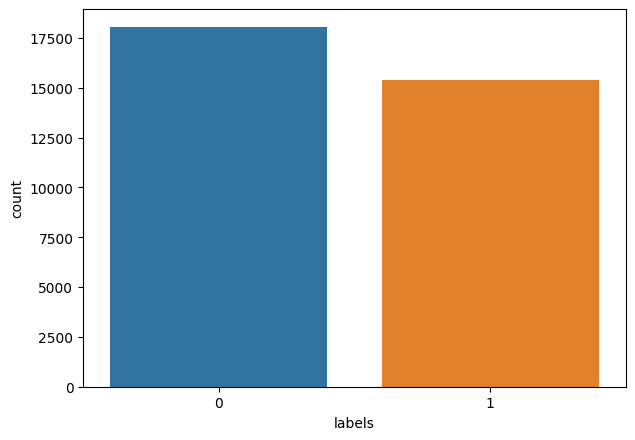

In [7]:
print(train_data["labels"].value_counts())
plt.figure(figsize=(7, 5), dpi = 100)
sns.countplot(train_data['labels']);

In [8]:
X = train_data["tweets"].tolist()
y = train_data["labels"].tolist()

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y,
                                                stratify = y,
                                                test_size = 0.1, 
                                                random_state = 101)

#### Create a mapping between word and id, ***word --> id***

In [10]:
idx = 1
word2idx = {"<unk>": 0}

for text in xtrain:
    text = text.replace("\n", " ")
    #text = text.translate(str.maketrans('','',string.punctuation))
    tokens = text.split()
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

##### Vocabulary

In [11]:
len(word2idx)

35989

#### Convert all the text tokens into ids using word2idx created above.

In [12]:
xtrain_int = []
xtest_int = []

for text in xtrain:
    text = text.replace("\n", " ")
    #text = text.translate(str.maketrans('','',string.punctuation))
    tokens = text.split()
    line_int = [word2idx[token] for token in tokens]
    xtrain_int.append(line_int)

for text in xtest:
    text = text.replace("\n", " ")
    #text = text.translate(str.maketrans('','',string.punctuation))
    tokens = text.split()
    line_int = [word2idx.get(token, 0) for token in tokens]
    xtest_int.append(line_int)

In [13]:
print("Text converted to id --->\n\n", xtrain_int[0], "\n\nText --->\n\n", xtrain[0])

Text converted to id --->

 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 

Text --->

 believe power ability make 19 offering laboratories facing uncertain times discounted prices help digitize research


#### We are creating seperate probabilistic model for each class.
- pi0 and pi1 are the initial state distributions, which relates to the first word in a sentence.
- a0 and a1 are the transition state matrix for each class, which contains log probabilities of transition between words.

In [14]:
V = len(word2idx)

a0 = np.ones((V, V))
pi0 = np.ones(V)

a1 = np.ones((V, V))
pi1 = np.ones(V)

#### Compute counts/frequence for initial state and transition state matrix.

In [15]:
def compute_counts(text_to_int, A, pi):
    for tokens in text_to_int:
        last_idx = None
        for idx in tokens:
            if last_idx is None:
                pi[idx] += 1
            else:
                A[last_idx, idx] += 1
            
            last_idx = idx
    
    return A, pi

a0, pi0 = compute_counts([x for x, y in zip(xtrain_int, ytrain) if y == 0], a0, pi0)
a1, pi1 = compute_counts([x for x, y in zip(xtrain_int, ytrain) if y == 1], a1, pi1)

#### Since working with high dimensional matrices consumes a lot of memory, we'll delete a0 & a1 after computing its log.

In [16]:
a0 /= a0.sum(axis=1, keepdims=True)

In [17]:
loga0 = np.log(a0)
del a0

In [18]:
pi0 /= pi0.sum()
logpi0 = np.log(pi0)
del pi0

In [19]:
a1 /= a1.sum(axis=1, keepdims=True)

In [20]:
loga1 = np.log(a1)
del a1

In [21]:
pi1 /= pi1.sum()
logpi1 = np.log(pi1)
del pi1

#### Calculate prior log probabilities for each class (positive and negative).

In [22]:
count0 = sum(y==0 for y in ytrain)
count1 = sum(y==1 for y in ytrain)

total = len(ytrain)

p0 = count0 / total
p1 = count1 / total

logp0 = np.log(p0)
logp1 = np.log(p1)

#### Define a class which incorporates functions like compute_log_likelihood & predict.

In [23]:
class Classifier:
    def __init__(self, logAs, logpis, logpriors):
        self.logAs = logAs
        self.logpis = logpis
        self.logpriors = logpriors
        self.K = len(logpriors)
    
    def compute_log_likelihood(self, input_, class_):
        logA = self.logAs[class_]
        logpi = self.logpis[class_]
        
        last_idx = None
        logprob = 0

        for idx in input_:
            if last_idx is None:
                logprob += logpi[idx]
            else:
                logprob += logA[last_idx, idx]
        
            last_idx = idx
        
        return logprob

    def predict(self, inputs):
        predictions = np.zeros(len(inputs))
        for e, input_ in enumerate(inputs):
            posteriors = [self.compute_log_likelihood(input_, c) + self.logpriors[c] for c in range(self.K)]
            prediction = np.argmax(posteriors)
            predictions[e] = prediction
        
        return predictions

In [24]:
clf = Classifier([loga0, loga1], [logpi0, logpi1], [logp0, logp1])
ptrain = clf.predict(xtrain_int)
ptest = clf.predict(xtest_int)

#### Classification report for training.

In [25]:
print(classification_report(ytrain, ptrain))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16239
           1       1.00      0.99      0.99     13857

    accuracy                           0.99     30096
   macro avg       0.99      0.99      0.99     30096
weighted avg       0.99      0.99      0.99     30096



#### Classification report for validation.

In [26]:
print(classification_report(ytest, ptest))

              precision    recall  f1-score   support

           0       0.70      0.84      0.77      1805
           1       0.76      0.59      0.66      1540

    accuracy                           0.72      3345
   macro avg       0.73      0.71      0.71      3345
weighted avg       0.73      0.72      0.72      3345



In [27]:
print("Training metrics --->\n")

print(f"F1-score - {f1_score(ytrain, ptrain):.3f}")
print(f"Precision - {precision_score(ytrain, ptrain):.3f}")
print(f"Recall - {recall_score(ytrain, ptrain):.3f}")
print(f"Auc - {roc_auc_score(ytrain, ptrain):.3f}")

Training metrics --->

F1-score - 0.993
Precision - 0.996
Recall - 0.990
Auc - 0.993


In [28]:
print("Validation metrics --->\n")
print(f"F1-score - {f1_score(ytest, ptest):.3f}")
print(f"Precision - {precision_score(ytest, ptest):.3f}")
print(f"Recall - {recall_score(ytest, ptest):.3f}")
print(f"Auc - {roc_auc_score(ytest, ptest):.3f}")

Validation metrics --->

F1-score - 0.661
Precision - 0.757
Recall - 0.587
Auc - 0.713
